# Tarea 01

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Input,Embedding,Flatten,Concatenate,Dropout,Conv2D,MaxPooling2D,GlobalAveragePooling2D,BatchNormalization,Lambda,TimeDistributed,GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from math import log2
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,SMOTENC
import os
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16, EfficientNetB0,MobileNetV3Small,MobileNetV2

In [2]:
PATH = '../pet_adoption/data.csv'

In [3]:
dataset = pd.read_csv(PATH)

## 1. Predicción utilizando datos tabulares

In [4]:
columnas_a_remover = ['AdoptionSpeed','PetID','Name']
columnas_categoricas_ohe =['Gender','Type','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health']
columnas_categoricas_emb = [
    "Breed1",
    "Breed2",
    "Color1",
    "Color2",
    "Color3",
    "State",
]
columnas_numericas = ["Age", "Fee", "PhotoAmt"]

In [5]:
X = dataset.drop(columns=columnas_a_remover)
y = dataset['AdoptionSpeed']

In [6]:
print(y[y==0].count())
print(y[y==1].count())
print(y[y==2].count())
print(y[y==3].count())
print(y[y==4].count())

310
2410
3138
2529
2943


Dataset desbalanceado

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
column_transformer = ColumnTransformer(
    [("category_encoder", OneHotEncoder( dtype=int), columnas_categoricas_ohe),
     ('numeric_scaler',StandardScaler(),columnas_numericas)],
    remainder="passthrough",
)

In [9]:
pipeline = Pipeline(
    steps=[("preprocessor", column_transformer)]
)

In [10]:
pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_encoder',
                                                  OneHotEncoder(dtype=<class 'int'>),
                                                  ['Gender', 'Type',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health']),
                                                 ('numeric_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'Fee',
                                                   'PhotoAmt'])]))])

In [11]:
columnas_encoded = []
for col in columnas_categoricas_ohe:
    for val in np.unique(X_train[col]):
        columnas_encoded.append(f"{col}_{val}")

In [12]:
class LabelEncoderWithUnknown(LabelEncoder):
    def __init__(self, unknown_label="unknown"):
        super().__init__()
        self.unknown_label = unknown_label

    def fit(self, y):
        y = list(y) + [self.unknown_label]
        super().fit(y)
        return self

    def transform(self, y):
        y = pd.Series(y).apply(
            lambda x: x if x in self.classes_ else self.unknown_label
        )
        return super().transform(y)

    def fit_transform(self, y):
        return self.fit(y).transform(y)

In [13]:
all_breeds = pd.concat([X["Breed1"], X["Breed2"]])
all_colors = pd.concat([X["Color1"], X["Color2"], X["Color3"]])

In [14]:
label_encoder_breeds = LabelEncoderWithUnknown()
label_encoder_breeds.fit(all_breeds)

label_encoder_colors = LabelEncoderWithUnknown()
label_encoder_colors.fit(all_colors)

label_encoder_state = LabelEncoderWithUnknown()
label_encoder_state.fit(X["State"])

LabelEncoderWithUnknown()

In [15]:
def preprocesar_columnas(dataset, pipeline,label_encoders):
    dataset_encoded=pipeline.transform(dataset)
    dataset_encoded = pd.DataFrame(
        dataset_encoded,
        columns=columnas_encoded + columnas_numericas + columnas_categoricas_emb
    )
    dataset_encoded["Breed1"] = label_encoders['breeds'].transform(dataset_encoded["Breed1"])
    dataset_encoded["Breed2"] = label_encoders['breeds'].transform(dataset_encoded["Breed2"])
    dataset_encoded["Color1"] = label_encoders['colors'].transform(dataset_encoded["Color1"])
    dataset_encoded["Color2"] = label_encoders['colors'].transform(dataset_encoded["Color2"])
    dataset_encoded["Color3"] = label_encoders['colors'].transform(dataset_encoded["Color3"])
    dataset_encoded["State"] = label_encoders['states'].transform(dataset_encoded["State"])
    return dataset_encoded

In [16]:
label_encoders={
    "breeds":label_encoder_breeds,
    "colors":label_encoder_colors,
    "states":label_encoder_state
}

In [17]:
X_encoded = preprocesar_columnas(X_train,pipeline,label_encoders)

In [18]:
X_encoded.head()

,Gender_1,Gender_2,Type_Cat,Type_Dog,MaturitySize_1,MaturitySize_2,MaturitySize_3,MaturitySize_4,FurLength_1,FurLength_2,...,Health_3,Age,Fee,PhotoAmt,Breed1,Breed2,Color1,Color2,Color3,State
0,1,0,0,1,0,1,0,0,1,0,...,0,0.278041,-0.306824,-0.854684,126,181,5,8,8,9
1,0,1,1,0,1,0,0,0,0,1,...,0,-0.50083,-0.306824,-0.854684,60,181,2,5,8,12
2,0,1,0,1,0,1,0,0,1,0,...,0,-0.552754,-0.306824,0.413421,108,181,0,5,8,8
3,1,0,0,1,1,0,0,0,1,0,...,0,0.174192,-0.306824,-0.220631,52,181,1,5,8,12
4,1,0,1,0,0,1,0,0,0,1,...,0,0.641514,1.67187,-0.854684,146,181,1,2,8,0


In [19]:
input_raza_1 = Input(shape=(1,),name='Breed1')
input_raza_2 = Input(shape=(1,),name='Breed2')
input_color_1 = Input(shape=(1,),name='Color1')
input_color_2 = Input(shape=(1,),name='Color2')
input_color_3 = Input(shape=(1,),name='Color3')
input_state = Input(shape=(1,),name='State')

input_gender_1 = Input(shape=(1,), name='Gender_1')
input_gender_2 = Input(shape=(1,), name='Gender_2')

input_type_cat = Input(shape=(1,), name='Type_Cat')
input_type_dog = Input(shape=(1,), name='Type_Dog')
input_maturity_size_1 = Input(shape=(1,), name='MaturitySize_1')
input_maturity_size_2 = Input(shape=(1,), name='MaturitySize_2')
input_maturity_size_3 = Input(shape=(1,), name='MaturitySize_3')
input_maturity_size_4 = Input(shape=(1,), name='MaturitySize_4')
input_fur_length_1 = Input(shape=(1,), name='FurLength_1')
input_fur_length_2 = Input(shape=(1,), name='FurLength_2')
input_fur_length_3 = Input(shape=(1,), name='FurLength_3')
input_vaccinated_1 = Input(shape=(1,), name='Vaccinated_1')
input_vaccinated_2 = Input(shape=(1,), name='Vaccinated_2')
input_vaccinated_3 = Input(shape=(1,), name='Vaccinated_3')
input_dewormed_1 = Input(shape=(1,), name='Dewormed_1')
input_dewormed_2 = Input(shape=(1,), name='Dewormed_2')
input_dewormed_3 = Input(shape=(1,), name='Dewormed_3')
input_sterilized_1 = Input(shape=(1,), name='Sterilized_1')
input_sterilized_2 = Input(shape=(1,), name='Sterilized_2')
input_sterilized_3 = Input(shape=(1,), name='Sterilized_3')
input_health_1 = Input(shape=(1,), name='Health_1')
input_health_2 = Input(shape=(1,), name='Health_2')
input_health_3 = Input(shape=(1,), name='Health_3')

input_age = Input(shape=(1,), name='Age')
input_fee = Input(shape=(1,), name='Fee')
input_photo_amt = Input(shape=(1,), name='PhotoAmt')


In [20]:
output_dim_breed = int(log2(len(label_encoder_breeds.classes_)))
output_dim_color = int(log2(len(label_encoder_colors.classes_)))
output_dim_state = int(log2(len(label_encoder_state.classes_)))

In [21]:
embedding_breed_1 = Embedding(input_dim=len(label_encoder_breeds.classes_), output_dim=output_dim_breed)(input_raza_1)
embedding_breed_2 = Embedding(input_dim=len(label_encoder_breeds.classes_), output_dim=output_dim_breed)(input_raza_2)
embedding_color_1 = Embedding(input_dim=len(label_encoder_colors.classes_), output_dim=output_dim_color)(input_color_1)
embedding_color_2 = Embedding(input_dim=len(label_encoder_colors.classes_), output_dim=output_dim_color)(input_color_2)
embedding_color_3 = Embedding(input_dim=len(label_encoder_colors.classes_), output_dim=output_dim_color)(input_color_3)
embedding_state = Embedding(input_dim=len(label_encoder_state.classes_), output_dim=output_dim_state)(input_state)

In [22]:
flatten_breed_1 = Flatten()(embedding_breed_1)
flatten_breed_2 = Flatten()(embedding_breed_2)
flatten_color_1 = Flatten()(embedding_color_1)
flatten_color_2 = Flatten()(embedding_color_2)
flatten_color_3 = Flatten()(embedding_color_3)
flatten_state = Flatten()(embedding_state)

In [23]:
concatenated = Concatenate()([flatten_breed_1,flatten_breed_2,flatten_color_1,flatten_color_2,flatten_color_3,flatten_state,
                              input_gender_1, input_gender_2, input_type_cat, input_type_dog, input_maturity_size_1, input_maturity_size_2,
                                input_maturity_size_3, input_maturity_size_4, input_fur_length_1, input_fur_length_2, input_fur_length_3,
                                input_vaccinated_1, input_vaccinated_2, input_vaccinated_3, input_dewormed_1, input_dewormed_2, input_dewormed_3,
                                input_sterilized_1, input_sterilized_2, input_sterilized_3, input_health_1, input_health_2, input_health_3,
                                input_age, input_fee, input_photo_amt])

In [24]:
x = Dense(1024, activation="relu")(concatenated)
x = Dropout(0.5)(x)
x = Dense(512,activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(256,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(5, activation="softmax")(x)

In [25]:
model = Model(inputs=[input_raza_1, input_raza_2, input_color_1, input_color_2, input_color_3, input_state,
                      input_gender_1, input_gender_2, input_type_cat,input_type_dog, input_maturity_size_1, input_maturity_size_2,
                      input_maturity_size_3, input_maturity_size_4, input_fur_length_1, input_fur_length_2, input_fur_length_3,
                      input_vaccinated_1, input_vaccinated_2, input_vaccinated_3, input_dewormed_1, input_dewormed_2, input_dewormed_3,
                      input_sterilized_1, input_sterilized_2, input_sterilized_3, input_health_1, input_health_2, input_health_3,
                      input_age, input_fee, input_photo_amt], outputs=output)

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Breed1 (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Breed2 (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Color1 (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Color2 (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Color3 (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ State (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 7)      │      1,274 │ Breed1[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 7)      │      1,274 │ Breed2[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 3)      │         27 │ Color1[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 3)      │         27 │ Color2[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 3)      │         27 │ Color3[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 3)      │         45 │ State[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 7)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 3)         │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 3)         │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 3)         │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Gender_1            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Gender_2            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Type_Cat            │ (None, 1)         │          0 │ -               

 Total params: 746,615 (2.85 MB)

 Trainable params: 746,615 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
X_test_encoded = preprocesar_columnas(X_test,pipeline,label_encoders)

In [29]:
X_test_encoded = X_test_encoded.astype(np.float32)
X_encoded = X_encoded.astype(np.float32)

In [30]:
X_encoded.head()

,Gender_1,Gender_2,Type_Cat,Type_Dog,MaturitySize_1,MaturitySize_2,MaturitySize_3,MaturitySize_4,FurLength_1,FurLength_2,...,Health_3,Age,Fee,PhotoAmt,Breed1,Breed2,Color1,Color2,Color3,State
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.278041,-0.306824,-0.854684,126.0,181.0,5.0,8.0,8.0,9.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.500830,-0.306824,-0.854684,60.0,181.0,2.0,5.0,8.0,12.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,-0.552754,-0.306824,0.413421,108.0,181.0,0.0,5.0,8.0,8.0
3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.174192,-0.306824,-0.220631,52.0,181.0,1.0,5.0,8.0,12.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.641514,1.671870,-0.854684,146.0,181.0,1.0,2.0,8.0,0.0


In [31]:
X_test_encoded.head()

,Gender_1,Gender_2,Type_Cat,Type_Dog,MaturitySize_1,MaturitySize_2,MaturitySize_3,MaturitySize_4,FurLength_1,FurLength_2,...,Health_3,Age,Fee,PhotoAmt,Breed1,Breed2,Color1,Color2,Color3,State
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,-0.448905,-0.306824,-0.220631,61.0,181.0,0.0,8.0,8.0,12.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,-0.448905,-0.306824,-0.854684,108.0,181.0,0.0,1.0,5.0,3.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,-0.345055,-0.306824,-0.537657,61.0,181.0,4.0,5.0,8.0,3.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,-0.552754,-0.306824,-0.220631,108.0,108.0,1.0,8.0,8.0,12.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,-0.241206,-0.306824,0.413421,121.0,59.0,0.0,1.0,8.0,12.0


In [32]:
print(y_train[y_train==0].count())
print(y_train[y_train==1].count())
print(y_train[y_train==2].count())
print(y_train[y_train==3].count())
print(y_train[y_train==4].count())

268
1959
2510
2001
2326


In [48]:
# borderline_smote = BorderlineSMOTE(random_state=42)
# X_encoded, y_train = borderline_smote.fit_resample(X_encoded, y_train)

In [34]:
# X_encoded, y_train = SMOTE(sampling_strategy={0: 2100}).fit_resample(X_encoded, y_train)

In [33]:
print(y_train[y_train == 0].count())
print(y_train[y_train == 1].count())
print(y_train[y_train == 2].count())
print(y_train[y_train == 3].count())
print(y_train[y_train == 4].count())

268
1959
2510
2001
2326


In [34]:
X_train_dict = {
    "Breed1": X_encoded["Breed1"],
    "Breed2": X_encoded["Breed2"],
    "Color1": X_encoded["Color1"],
    "Color2": X_encoded["Color2"],
    "Color3": X_encoded["Color3"],
    "State": X_encoded["State"],
    "Gender_1": X_encoded['Gender_1'],
    "Gender_2": X_encoded['Gender_2'],
    "Type_Cat": X_encoded['Type_Cat'],
    "Type_Dog": X_encoded['Type_Dog'],
    "MaturitySize_1": X_encoded['MaturitySize_1'],
    "MaturitySize_2": X_encoded['MaturitySize_2'],
    "MaturitySize_3": X_encoded['MaturitySize_3'],
    "MaturitySize_4": X_encoded['MaturitySize_4'],
    "FurLength_1": X_encoded['FurLength_1'],
    "FurLength_2": X_encoded['FurLength_2'],
    "FurLength_3": X_encoded['FurLength_3'],
    "Vaccinated_1": X_encoded['Vaccinated_1'],
    "Vaccinated_2": X_encoded['Vaccinated_2'],
    "Vaccinated_3": X_encoded['Vaccinated_3'],
    "Dewormed_1": X_encoded['Dewormed_1'],
    "Dewormed_2": X_encoded['Dewormed_2'],
    "Dewormed_3": X_encoded['Dewormed_3'],
    "Sterilized_1": X_encoded['Sterilized_1'],
    "Sterilized_2": X_encoded['Sterilized_2'],
    "Sterilized_3": X_encoded['Sterilized_3'],
    "Health_1": X_encoded['Health_1'],
    "Health_2": X_encoded['Health_2'],
    "Health_3": X_encoded['Health_3'],
    "Age": X_encoded['Age'],
    "Fee": X_encoded['Fee'],
    "PhotoAmt": X_encoded['PhotoAmt']
}

X_test_dict = {
    "Breed1": X_test_encoded["Breed1"],
    "Breed2": X_test_encoded["Breed2"],
    "Color1": X_test_encoded["Color1"],
    "Color2": X_test_encoded["Color2"],
    "Color3": X_test_encoded["Color3"],
    "State": X_test_encoded["State"],
    "Gender_1": X_test_encoded["Gender_1"],
    "Gender_2": X_test_encoded["Gender_2"],
    "Type_Cat": X_test_encoded["Type_Cat"],
    "Type_Dog": X_test_encoded["Type_Dog"],
    "MaturitySize_1": X_test_encoded["MaturitySize_1"],
    "MaturitySize_2": X_test_encoded["MaturitySize_2"],
    "MaturitySize_3": X_test_encoded["MaturitySize_3"],
    "MaturitySize_4": X_test_encoded["MaturitySize_4"],
    "FurLength_1": X_test_encoded["FurLength_1"],
    "FurLength_2": X_test_encoded["FurLength_2"],
    "FurLength_3": X_test_encoded["FurLength_3"],
    "Vaccinated_1": X_test_encoded["Vaccinated_1"],
    "Vaccinated_2": X_test_encoded["Vaccinated_2"],
    "Vaccinated_3": X_test_encoded["Vaccinated_3"],
    "Dewormed_1": X_test_encoded["Dewormed_1"],
    "Dewormed_2": X_test_encoded["Dewormed_2"],
    "Dewormed_3": X_test_encoded["Dewormed_3"],
    "Sterilized_1": X_test_encoded["Sterilized_1"],
    "Sterilized_2": X_test_encoded["Sterilized_2"],
    "Sterilized_3": X_test_encoded["Sterilized_3"],
    "Health_1": X_test_encoded["Health_1"],
    "Health_2": X_test_encoded["Health_2"],
    "Health_3": X_test_encoded["Health_3"],
    "Age": X_test_encoded["Age"],
    "Fee": X_test_encoded["Fee"],
    "PhotoAmt": X_test_encoded["PhotoAmt"],
}

In [35]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, verbose=1, mode="min", min_lr=0.001
)

callbacks = [ reduce_lr]

In [36]:
history = model.fit(X_train_dict, y_train, epochs=50, validation_data=(X_test_dict, y_test),callbacks=callbacks,verbose=1)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3009 - loss: 1.4716 - val_accuracy: 0.3517 - val_loss: 1.3885 - learning_rate: 0.0010
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3534 - loss: 1.4114 - val_accuracy: 0.3778 - val_loss: 1.3619 - learning_rate: 0.0010
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3889 - loss: 1.3836 - val_accuracy: 0.3764 - val_loss: 1.3663 - learning_rate: 0.0010
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3820 - loss: 1.3737 - val_accuracy: 0.3923 - val_loss: 1.3467 - learning_rate: 0.0010
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3972 - loss: 1.3585 - val_accuracy: 0.3853 - val_loss: 1.3507 - learning_rate: 0.0010
Epoch 6/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3948 - loss: 1.3491 - val_accuracy: 0.3950 - val_loss: 1.3423 - learning_rate: 0.0010
Epoch 7/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4047 - loss: 1.3502 - 

In [37]:
prediciones=model.predict(X_test_dict)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [38]:
predicciones_clase = np.argmax(prediciones,axis=1)

In [39]:
matriz_confusion = confusion_matrix(y_test,predicciones_clase)

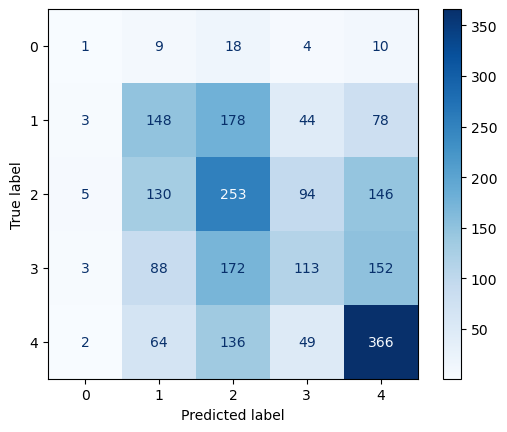

In [40]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusion
)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 2. Predicción utilizando datos visuales

In [41]:
PATH_IMAGES_FOLDER = '../pet_adoption/images/'

In [6]:
dataset['PhotoAmt'].describe()

count    11330.000000
mean         3.682524
std          3.131945
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         30.000000
Name: PhotoAmt, dtype: float64

In [42]:
dataset_cnn = dataset[['AdoptionSpeed','PetID','PhotoAmt']]

In [43]:
image_files = [
    f
    for f in os.listdir(PATH_IMAGES_FOLDER)
    if os.path.isfile(os.path.join(PATH_IMAGES_FOLDER, f))
]

In [44]:
dataset_cnn.head()

,AdoptionSpeed,PetID,PhotoAmt
0,2,86e1089a3,1
1,0,6296e909a,2
2,3,3422e4906,7
3,2,5842f1ff5,8
4,2,850a43f90,3


In [45]:
X = dataset_cnn.drop(columns=['AdoptionSpeed'])
y = dataset_cnn['AdoptionSpeed']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
X_train.head()

,PetID,PhotoAmt
10600,cbd6b3064,1
5090,50503b223,1
2919,81075b785,5
4889,d76c4ec1e,3
715,ab8386c6d,1


In [48]:
def load_image(image_path):
    img = Image.open(image_path)
    return img


def visualize_images(image_files, image_folder, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img_path = os.path.join(image_folder, image_files[i])
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(image_files[i])
        plt.axis("off")
    plt.show()

In [49]:
from collections import defaultdict

# Agrupa imágenes por PetID
imagenes_por_pet_id = defaultdict(list)
for img_file in image_files:
    pet_id = img_file.split("-")[0]  # Asumiendo que 'pet_id' se puede extraer así
    imagenes_por_pet_id[pet_id].append(img_file)

In [50]:
from concurrent.futures import ThreadPoolExecutor


def procesar_imagen(path_img):
    img = load_image(os.path.join(PATH_IMAGES_FOLDER, path_img))
    img = img.resize((128, 128))
    img_array = np.array(img)
    if img_array.ndim != 3:
        img_array = np.repeat(img_array[:, :, np.newaxis], 3, axis=2)
    return img_array


In [51]:
def generar_df_imgs(imagenes_por_pet_id, dataset, y):
    data = []
    y_imgs = []
    photo_amounts = dataset.set_index("PetID")["PhotoAmt"].to_dict()
    for index,pet_id in enumerate(dataset["PetID"]):
        cantidad_imagenes = photo_amounts[pet_id]
        imagenes_encontradas = imagenes_por_pet_id[pet_id]
        if cantidad_imagenes==len(imagenes_encontradas):
            with ThreadPoolExecutor(max_workers=4) as executor:
                futures = [executor.submit(procesar_imagen, img) for img in imagenes_encontradas]
                imagenes_procesadas = [f.result() for f in futures]
                if len(imagenes_procesadas)>4:
                    imagenes_procesadas = imagenes_procesadas[:4]
                elif len(imagenes_procesadas)<4:
                    imagenes_procesadas = imagenes_procesadas + [np.zeros((128,128,3)) for _ in range(4-len(imagenes_procesadas))]
                data.append(
                    [
                        pet_id,
                        imagenes_procesadas,
                        cantidad_imagenes
                    ]
                )
                y_imgs.append(
                    y.iloc[index]
                )
    df = pd.DataFrame(
        data,
        columns=["PetId", "img_array", "PhotoAmt"]
    )
    y_df = pd.Series(
        y_imgs
    )
    return df,y_df

In [52]:
df_imgs, y_imgs = generar_df_imgs(imagenes_por_pet_id, X_train, y_train)

In [53]:
df_imgs.head()

,PetId,img_array,PhotoAmt
0,cbd6b3064,"[[[[ 72 100 42], [ 72 100 42], [ 73 101 43]...",1
1,50503b223,"[[[[49 26 32], [49 26 32], [45 22 28], [49 26 ...",1
2,81075b785,"[[[[140 128 130], [140 128 130], [140 128 130]...",5
3,d76c4ec1e,"[[[[42 43 37], [44 45 39], [36 37 31], [39 40 ...",3
4,ab8386c6d,"[[[[73 73 64], [17 13 13], [43 36 33], [100 9...",1


In [55]:
df_test_imgs, y_test_imgs = generar_df_imgs(imagenes_por_pet_id, X_test, y_test)

In [54]:
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(5, activation='softmax')
# ])

/Users/marcofura/anaconda3/envs/fundamentos_matematicos/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:

base_model = MobileNetV3Small(
    weights="imagenet", include_top=False, input_shape=(128, 128, 3)
)

/Users/marcofura/anaconda3/envs/fundamentos_matematicos/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [57]:
for layer in base_model.layers:
    layer.trainable = False

In [58]:
def extract_features(input_img):
    x = base_model(input_img)
    x = GlobalAveragePooling2D()(x)
    return x


# Inputs para las 3 imágenes del registro
input_img1 = Input(shape=(128, 128, 3), name="img1")
input_img2 = Input(shape=(128, 128, 3), name="img2")
input_img3 = Input(shape=(128, 128, 3), name="img3")
input_img4 = Input(shape=(128, 128, 3), name="img4")

# Extraer características para cada imagen
features_img1 = extract_features(input_img1)
features_img2 = extract_features(input_img2)
features_img3 = extract_features(input_img3)
features_img4 = extract_features(input_img4)

# Concatenar las características de las 3 imágenes
concatenated_features = Concatenate()([features_img1, features_img2, features_img3,features_img4])

In [59]:
x = Dense(512, activation="relu")(concatenated_features)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation="softmax")(
    x
) 

# Crear el modelo final
tf_model = Model(inputs=[input_img1,input_img2,input_img3,input_img4], outputs=predictions)

In [60]:
tf_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [61]:
print(df_imgs.shape, type(df_imgs))
print(df_test_imgs.shape, type(df_test_imgs))
print(y_imgs.shape, type(y_imgs))
print(y_test_imgs.shape, type(y_test_imgs))

(9064, 3) <class 'pandas.core.frame.DataFrame'>
(2266, 3) <class 'pandas.core.frame.DataFrame'>
(9064,) <class 'pandas.core.series.Series'>
(2266,) <class 'pandas.core.series.Series'>


In [62]:
X_imgs1 = np.array([img_list[0] for img_list in df_imgs["img_array"]])  # Primera imagen
X_imgs2 = np.array([img_list[1] for img_list in df_imgs["img_array"]])  # Segunda imagen
X_imgs3 = np.array([img_list[2] for img_list in df_imgs["img_array"]])
X_imgs4 = np.array([img_list[3] for img_list in df_imgs["img_array"]])

In [63]:
X_val_imgs1 = np.array([img_list[0] for img_list in df_test_imgs["img_array"]])  # Primera imagen
X_val_imgs2 = np.array([img_list[1] for img_list in df_test_imgs["img_array"]])  # Segunda imagen
X_val_imgs3 = np.array([img_list[2] for img_list in df_test_imgs["img_array"]])
X_val_imgs4 = np.array([img_list[3] for img_list in df_test_imgs["img_array"]])

In [64]:
history = tf_model.fit(
    [X_imgs1,X_imgs2,X_imgs3,X_imgs4],y_imgs, epochs=50, validation_data=([X_val_imgs1,X_val_imgs2,X_val_imgs3,X_val_imgs4],y_test_imgs), verbose=1
)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.2586 - loss: 1.7545 - val_accuracy: 0.2829 - val_loss: 1.4683
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.2839 - loss: 1.4991 - val_accuracy: 0.2732 - val_loss: 1.4718
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.2869 - loss: 1.4733 - val_accuracy: 0.3191 - val_loss: 1.4513
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - accuracy: 0.3004 - loss: 1.4753 - val_accuracy: 0.3279 - val_loss: 1.4423
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.3168 - loss: 1.4573 - val_accuracy: 0.3270 - val_loss: 1.4434
Epoch 6/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - accuracy: 0.3169 - loss: 1.4518 - val_accuracy: 0.3244 - val_loss: 1.4361
Epoch 7/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.3274 - loss: 1.4409 - val_accuracy: 0.3327 - val_loss: 1.4243
Epoch 8/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.3333 - loss: 1.4374 -

KeyboardInterrupt: 

## 3. Predicción multimodal

In [65]:
columnas_a_remover = ["AdoptionSpeed", "Name"]
columnas_categoricas_ohe = [
    "Gender",
    "Type",
    "MaturitySize",
    "FurLength",
    "Vaccinated",
    "Dewormed",
    "Sterilized",
    "Health",
]
columnas_categoricas_emb = [
    "Breed1",
    "Breed2",
    "Color1",
    "Color2",
    "Color3",
    "State",
]
columnas_numericas = ["Age", "Fee", "PhotoAmt"]

In [66]:
image_files = [
    f
    for f in os.listdir(PATH_IMAGES_FOLDER)
    if os.path.isfile(os.path.join(PATH_IMAGES_FOLDER, f))
]

In [67]:
X = dataset.drop(columns=columnas_a_remover)
y = dataset["AdoptionSpeed"]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [69]:
column_transformer = ColumnTransformer(
    [
        ("category_encoder", OneHotEncoder(dtype=int), columnas_categoricas_ohe),
        ("numeric_scaler", StandardScaler(), columnas_numericas),
    ],
    remainder="passthrough",
)

In [70]:
pipeline = Pipeline(steps=[("preprocessor", column_transformer)])

In [71]:
pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_encoder',
                                                  OneHotEncoder(dtype=<class 'int'>),
                                                  ['Gender', 'Type',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health']),
                                                 ('numeric_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'Fee',
                                                   'PhotoAmt'])]))])

In [72]:
columnas_encoded = []
for col in columnas_categoricas_ohe:
    for val in np.unique(X_train[col]):
        columnas_encoded.append(f"{col}_{val}")

In [73]:
class LabelEncoderWithUnknown(LabelEncoder):
    def __init__(self, unknown_label="unknown"):
        super().__init__()
        self.unknown_label = unknown_label

    def fit(self, y):
        y = list(y) + [self.unknown_label]
        super().fit(y)
        return self

    def transform(self, y):
        y = pd.Series(y).apply(
            lambda x: x if x in self.classes_ else self.unknown_label
        )
        return super().transform(y)

    def fit_transform(self, y):
        return self.fit(y).transform(y)

In [74]:
all_breeds = pd.concat([X["Breed1"], X["Breed2"]])
all_colors = pd.concat([X["Color1"], X["Color2"], X["Color3"]])

In [75]:
label_encoder_breeds = LabelEncoderWithUnknown()
label_encoder_breeds.fit(all_breeds)

label_encoder_colors = LabelEncoderWithUnknown()
label_encoder_colors.fit(all_colors)

label_encoder_state = LabelEncoderWithUnknown()
label_encoder_state.fit(X["State"])

LabelEncoderWithUnknown()

In [76]:
def preprocesar_columnas(dataset, pipeline, label_encoders):
    dataset_encoded = pipeline.transform(dataset)
    dataset_encoded = pd.DataFrame(
        dataset_encoded,
        columns=columnas_encoded + columnas_numericas + columnas_categoricas_emb + ['PetID'],
    )
    dataset_encoded["Breed1"] = label_encoders["breeds"].transform(
        dataset_encoded["Breed1"]
    )
    dataset_encoded["Breed2"] = label_encoders["breeds"].transform(
        dataset_encoded["Breed2"]
    )
    dataset_encoded["Color1"] = label_encoders["colors"].transform(
        dataset_encoded["Color1"]
    )
    dataset_encoded["Color2"] = label_encoders["colors"].transform(
        dataset_encoded["Color2"]
    )
    dataset_encoded["Color3"] = label_encoders["colors"].transform(
        dataset_encoded["Color3"]
    )
    dataset_encoded["State"] = label_encoders["states"].transform(
        dataset_encoded["State"]
    )
    return dataset_encoded

In [77]:
label_encoders = {
    "breeds": label_encoder_breeds,
    "colors": label_encoder_colors,
    "states": label_encoder_state,
}

In [78]:
X_encoded = preprocesar_columnas(X_train, pipeline, label_encoders)

In [79]:
X_encoded.head()

,Gender_1,Gender_2,Type_Cat,Type_Dog,MaturitySize_1,MaturitySize_2,MaturitySize_3,MaturitySize_4,FurLength_1,FurLength_2,...,Age,Fee,PhotoAmt,Breed1,Breed2,Color1,Color2,Color3,State,PetID
0,0,1,0,1,0,1,0,0,1,0,...,-0.293352,-0.296028,-0.221189,108,181,0,1,2,12,f75724b44
1,1,0,0,1,1,0,0,0,1,0,...,3.120085,-0.296028,0.0972,107,181,1,8,8,12,6f93a41c5
2,1,0,0,1,0,1,0,0,0,1,...,-0.500227,-0.296028,-0.857966,108,181,0,8,8,12,9031a7f4c
3,1,0,1,0,0,1,0,0,1,0,...,-0.500227,-0.296028,-0.221189,61,181,0,8,8,12,74e18bd5e
4,1,0,0,1,0,1,0,0,0,1,...,3.120085,-0.296028,-0.539578,108,181,3,8,8,12,0063bd7e0


In [80]:
def load_image(image_path):
    img = Image.open(image_path)
    return img


def visualize_images(image_files, image_folder, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img_path = os.path.join(image_folder, image_files[i])
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(image_files[i])
        plt.axis("off")
    plt.show()

In [81]:
from collections import defaultdict

# Agrupa imágenes por PetID
imagenes_por_pet_id = defaultdict(list)
for img_file in image_files:
    pet_id = img_file.split("-")[0]  # Asumiendo que 'pet_id' se puede extraer así
    imagenes_por_pet_id[pet_id].append(img_file)

In [82]:
from concurrent.futures import ThreadPoolExecutor


def procesar_imagen(path_img):
    img = load_image(os.path.join(PATH_IMAGES_FOLDER, path_img))
    img = img.resize((128, 128))
    img_array = np.array(img)
    if img_array.ndim != 3:
        img_array = np.repeat(img_array[:, :, np.newaxis], 3, axis=2)
    return img_array

In [83]:
def generar_df_imgs(imagenes_por_pet_id, dataset, y):
    data = []
    y_imgs = []
    photo_amounts = dataset.set_index("PetID")["PhotoAmt"].to_dict()
    for index, pet_id in enumerate(dataset["PetID"]):
        cantidad_imagenes = photo_amounts[pet_id]
        imagenes_encontradas = imagenes_por_pet_id[pet_id]
        with ThreadPoolExecutor(max_workers=4) as executor:
            futures = [
                executor.submit(procesar_imagen, img)
                for img in imagenes_encontradas
            ]
            imagenes_procesadas = [f.result() for f in futures]
            if len(imagenes_procesadas)>4:
                imagenes_procesadas = imagenes_procesadas[:4]
            elif len(imagenes_procesadas)<4:
                imagenes_procesadas = imagenes_procesadas + [np.zeros((128,128,3)) for _ in range(4-len(imagenes_procesadas))]
            additional_columns = (
                dataset.loc[dataset["PetID"] == pet_id].iloc[0].to_dict()
            )
            # Crear una lista con los valores de las columnas adicionales
            additional_values = [
                additional_columns[col]
                for col in dataset.columns
                if col != "PetID"
            ]
            data.append([pet_id, imagenes_procesadas] + additional_values)
            y_imgs.append(y.iloc[index])
    
    df = pd.DataFrame(data, columns=["PetId", "img_array"]+[col for col in dataset.columns if col != "PetID"])
    y_df = pd.Series(y_imgs)
    return df, y_df

In [84]:
df_imgs, y_imgs = generar_df_imgs(imagenes_por_pet_id, X_encoded, y_train)

In [85]:
base_model = MobileNetV3Small(
    weights="imagenet", include_top=False, input_shape=(128, 128, 3)
)

/Users/marcofura/anaconda3/envs/fundamentos_matematicos/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [86]:
for layer in base_model.layers:
    layer.trainable = False

In [87]:
def extract_features(input_img):
    x = base_model(input_img)
    x = GlobalAveragePooling2D()(x)
    return x


# Inputs para las 3 imágenes del registro
input_img1 = Input(shape=(128, 128, 3), name="img1")
input_img2 = Input(shape=(128, 128, 3), name="img2")
input_img3 = Input(shape=(128, 128, 3), name="img3")
input_img4 = Input(shape=(128, 128, 3), name="img4")

# Extraer características para cada imagen
features_img1 = extract_features(input_img1)
features_img2 = extract_features(input_img2)
features_img3 = extract_features(input_img3)
features_img4 = extract_features(input_img4)

# Concatenar las características de las 3 imágenes
concatenated_features = Concatenate()(
    [features_img1, features_img2, features_img3, features_img4]
)

In [88]:
output_cnn = Dense(512, activation="relu")(concatenated_features)
output_cnn = Dropout(0.5)(output_cnn)
output_cnn = Dense(256, activation="relu")(output_cnn)
output_cnn = Dropout(0.5)(output_cnn)
output_cnn = Dense(128, activation="relu")(output_cnn)
output_cnn = Dropout(0.3)(output_cnn)

In [89]:
input_raza_1 = Input(shape=(1,), name="Breed1")
input_raza_2 = Input(shape=(1,), name="Breed2")
input_color_1 = Input(shape=(1,), name="Color1")
input_color_2 = Input(shape=(1,), name="Color2")
input_color_3 = Input(shape=(1,), name="Color3")
input_state = Input(shape=(1,), name="State")

input_gender_1 = Input(shape=(1,), name="Gender_1")
input_gender_2 = Input(shape=(1,), name="Gender_2")

input_type_cat = Input(shape=(1,), name="Type_Cat")
input_type_dog = Input(shape=(1,), name="Type_Dog")
input_maturity_size_1 = Input(shape=(1,), name="MaturitySize_1")
input_maturity_size_2 = Input(shape=(1,), name="MaturitySize_2")
input_maturity_size_3 = Input(shape=(1,), name="MaturitySize_3")
input_maturity_size_4 = Input(shape=(1,), name="MaturitySize_4")
input_fur_length_1 = Input(shape=(1,), name="FurLength_1")
input_fur_length_2 = Input(shape=(1,), name="FurLength_2")
input_fur_length_3 = Input(shape=(1,), name="FurLength_3")
input_vaccinated_1 = Input(shape=(1,), name="Vaccinated_1")
input_vaccinated_2 = Input(shape=(1,), name="Vaccinated_2")
input_vaccinated_3 = Input(shape=(1,), name="Vaccinated_3")
input_dewormed_1 = Input(shape=(1,), name="Dewormed_1")
input_dewormed_2 = Input(shape=(1,), name="Dewormed_2")
input_dewormed_3 = Input(shape=(1,), name="Dewormed_3")
input_sterilized_1 = Input(shape=(1,), name="Sterilized_1")
input_sterilized_2 = Input(shape=(1,), name="Sterilized_2")
input_sterilized_3 = Input(shape=(1,), name="Sterilized_3")
input_health_1 = Input(shape=(1,), name="Health_1")
input_health_2 = Input(shape=(1,), name="Health_2")
input_health_3 = Input(shape=(1,), name="Health_3")

input_age = Input(shape=(1,), name="Age")
input_fee = Input(shape=(1,), name="Fee")
input_photo_amt = Input(shape=(1,), name="PhotoAmt")

In [90]:
output_dim_breed = int(log2(len(label_encoder_breeds.classes_)))
output_dim_color = int(log2(len(label_encoder_colors.classes_)))
output_dim_state = int(log2(len(label_encoder_state.classes_)))

In [91]:
embedding_breed_1 = Embedding(
    input_dim=len(label_encoder_breeds.classes_), output_dim=output_dim_breed
)(input_raza_1)
embedding_breed_2 = Embedding(
    input_dim=len(label_encoder_breeds.classes_), output_dim=output_dim_breed
)(input_raza_2)
embedding_color_1 = Embedding(
    input_dim=len(label_encoder_colors.classes_), output_dim=output_dim_color
)(input_color_1)
embedding_color_2 = Embedding(
    input_dim=len(label_encoder_colors.classes_), output_dim=output_dim_color
)(input_color_2)
embedding_color_3 = Embedding(
    input_dim=len(label_encoder_colors.classes_), output_dim=output_dim_color
)(input_color_3)
embedding_state = Embedding(
    input_dim=len(label_encoder_state.classes_), output_dim=output_dim_state
)(input_state)

In [92]:
flatten_breed_1 = Flatten()(embedding_breed_1)
flatten_breed_2 = Flatten()(embedding_breed_2)
flatten_color_1 = Flatten()(embedding_color_1)
flatten_color_2 = Flatten()(embedding_color_2)
flatten_color_3 = Flatten()(embedding_color_3)
flatten_state = Flatten()(embedding_state)

In [93]:
input_mlp = Concatenate()(
    [
        flatten_breed_1,
        flatten_breed_2,
        flatten_color_1,
        flatten_color_2,
        flatten_color_3,
        flatten_state,
        input_gender_1,
        input_gender_2,
        input_type_cat,
        input_type_dog,
        input_maturity_size_1,
        input_maturity_size_2,
        input_maturity_size_3,
        input_maturity_size_4,
        input_fur_length_1,
        input_fur_length_2,
        input_fur_length_3,
        input_vaccinated_1,
        input_vaccinated_2,
        input_vaccinated_3,
        input_dewormed_1,
        input_dewormed_2,
        input_dewormed_3,
        input_sterilized_1,
        input_sterilized_2,
        input_sterilized_3,
        input_health_1,
        input_health_2,
        input_health_3,
        input_age,
        input_fee,
        input_photo_amt,
    ]
)

In [94]:
z = Dense(1024, activation="relu")(input_mlp)
z = Dropout(0.5)(z)
z = Dense(512, activation="relu")(z)
z = Dropout(0.5)(z)
z = Dense(256, activation="relu")(z)
z = Dropout(0.4)(z)
z = Dense(128, activation="relu")(z)
ouput_mlp = Dropout(0.3)(z)

In [95]:
combined = Concatenate()([output_cnn, ouput_mlp])
combined = Dense(256, activation="relu")(combined)
combined = Dropout(0.5)(combined)
combined = Dense(128, activation="relu")(combined)
combined = Dropout(0.3)(combined)
output = Dense(5, activation="softmax")(combined)

In [96]:
model = Model(
    inputs=[
        input_raza_1,
        input_raza_2,
        input_color_1,
        input_color_2,
        input_color_3,
        input_state,
        input_gender_1,
        input_gender_2,
        input_type_cat,
        input_type_dog,
        input_maturity_size_1,
        input_maturity_size_2,
        input_maturity_size_3,
        input_maturity_size_4,
        input_fur_length_1,
        input_fur_length_2,
        input_fur_length_3,
        input_vaccinated_1,
        input_vaccinated_2,
        input_vaccinated_3,
        input_dewormed_1,
        input_dewormed_2,
        input_dewormed_3,
        input_sterilized_1,
        input_sterilized_2,
        input_sterilized_3,
        input_health_1,
        input_health_2,
        input_health_3,
        input_age,
        input_fee,
        input_photo_amt,
        input_img1,
        input_img2,
        input_img3,
        input_img4
        
    ],
    outputs=output,
)

In [97]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [98]:
X_test_encoded = preprocesar_columnas(X_test, pipeline, label_encoders)

In [99]:
df_img_test, y_img_test = generar_df_imgs(imagenes_por_pet_id, X_test_encoded, y_test)

In [100]:
df_imgs = df_imgs.drop(columns=['PetId'])

In [101]:
df_img_test = df_img_test.drop(columns=['PetId'])

In [102]:
X_encoded = df_imgs
X_test_encoded = df_img_test

In [103]:
X_imgs1 = np.array([img_list[0] for img_list in df_imgs["img_array"]])  # Primera imagen
X_imgs2 = np.array([img_list[1] for img_list in df_imgs["img_array"]])  # Segunda imagen
X_imgs3 = np.array([img_list[2] for img_list in df_imgs["img_array"]])
X_imgs4 = np.array([img_list[3] for img_list in df_imgs["img_array"]])

In [104]:
X_val_imgs1 = np.array(
    [img_list[0] for img_list in df_img_test["img_array"]]
)  # Primera imagen
X_val_imgs2 = np.array(
    [img_list[1] for img_list in df_img_test["img_array"]]
)  # Segunda imagen
X_val_imgs3 = np.array([img_list[2] for img_list in df_img_test["img_array"]])
X_val_imgs4 = np.array([img_list[3] for img_list in df_img_test["img_array"]])

In [105]:
X_train_dict = {
    "Breed1": X_encoded["Breed1"],
    "Breed2": X_encoded["Breed2"],
    "Color1": X_encoded["Color1"],
    "Color2": X_encoded["Color2"],
    "Color3": X_encoded["Color3"],
    "State": X_encoded["State"],
    "Gender_1": X_encoded["Gender_1"],
    "Gender_2": X_encoded["Gender_2"],
    "Type_Cat": X_encoded["Type_Cat"],
    "Type_Dog": X_encoded["Type_Dog"],
    "MaturitySize_1": X_encoded["MaturitySize_1"],
    "MaturitySize_2": X_encoded["MaturitySize_2"],
    "MaturitySize_3": X_encoded["MaturitySize_3"],
    "MaturitySize_4": X_encoded["MaturitySize_4"],
    "FurLength_1": X_encoded["FurLength_1"],
    "FurLength_2": X_encoded["FurLength_2"],
    "FurLength_3": X_encoded["FurLength_3"],
    "Vaccinated_1": X_encoded["Vaccinated_1"],
    "Vaccinated_2": X_encoded["Vaccinated_2"],
    "Vaccinated_3": X_encoded["Vaccinated_3"],
    "Dewormed_1": X_encoded["Dewormed_1"],
    "Dewormed_2": X_encoded["Dewormed_2"],
    "Dewormed_3": X_encoded["Dewormed_3"],
    "Sterilized_1": X_encoded["Sterilized_1"],
    "Sterilized_2": X_encoded["Sterilized_2"],
    "Sterilized_3": X_encoded["Sterilized_3"],
    "Health_1": X_encoded["Health_1"],
    "Health_2": X_encoded["Health_2"],
    "Health_3": X_encoded["Health_3"],
    "Age": X_encoded["Age"],
    "Fee": X_encoded["Fee"],
    "PhotoAmt": X_encoded["PhotoAmt"],
    "img1": X_imgs1,
    "img2": X_imgs2,
    "img3": X_imgs3,
    "img4": X_imgs4
}

X_test_dict = {
    "Breed1": X_test_encoded["Breed1"],
    "Breed2": X_test_encoded["Breed2"],
    "Color1": X_test_encoded["Color1"],
    "Color2": X_test_encoded["Color2"],
    "Color3": X_test_encoded["Color3"],
    "State": X_test_encoded["State"],
    "Gender_1": X_test_encoded["Gender_1"],
    "Gender_2": X_test_encoded["Gender_2"],
    "Type_Cat": X_test_encoded["Type_Cat"],
    "Type_Dog": X_test_encoded["Type_Dog"],
    "MaturitySize_1": X_test_encoded["MaturitySize_1"],
    "MaturitySize_2": X_test_encoded["MaturitySize_2"],
    "MaturitySize_3": X_test_encoded["MaturitySize_3"],
    "MaturitySize_4": X_test_encoded["MaturitySize_4"],
    "FurLength_1": X_test_encoded["FurLength_1"],
    "FurLength_2": X_test_encoded["FurLength_2"],
    "FurLength_3": X_test_encoded["FurLength_3"],
    "Vaccinated_1": X_test_encoded["Vaccinated_1"],
    "Vaccinated_2": X_test_encoded["Vaccinated_2"],
    "Vaccinated_3": X_test_encoded["Vaccinated_3"],
    "Dewormed_1": X_test_encoded["Dewormed_1"],
    "Dewormed_2": X_test_encoded["Dewormed_2"],
    "Dewormed_3": X_test_encoded["Dewormed_3"],
    "Sterilized_1": X_test_encoded["Sterilized_1"],
    "Sterilized_2": X_test_encoded["Sterilized_2"],
    "Sterilized_3": X_test_encoded["Sterilized_3"],
    "Health_1": X_test_encoded["Health_1"],
    "Health_2": X_test_encoded["Health_2"],
    "Health_3": X_test_encoded["Health_3"],
    "Age": X_test_encoded["Age"],
    "Fee": X_test_encoded["Fee"],
    "PhotoAmt": X_test_encoded["PhotoAmt"],
    "img1": X_val_imgs1,
    "img2": X_val_imgs2,
    "img3": X_val_imgs3,
    "img4": X_val_imgs4
}

In [106]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, verbose=1, mode="min", min_lr=0.001
)

callbacks = [reduce_lr]

In [107]:
print(X_train_dict['img1'].shape)
print(X_train_dict['Age'].shape)
print(X_test_dict['img1'].shape)
print(X_test_dict['Age'].shape)

(10197, 128, 128, 3)
(10197,)
(1133, 128, 128, 3)
(1133,)


In [108]:
history = model.fit(
    X_train_dict,
    y_imgs,
    epochs=50,
    validation_data=(X_test_dict, y_img_test),
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 36s 87ms/step - accuracy: 0.2532 - loss: 1.6207 - val_accuracy: 0.3407 - val_loss: 1.4528 - learning_rate: 0.0010
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.2962 - loss: 1.4748 - val_accuracy: 0.3601 - val_loss: 1.4065 - learning_rate: 0.0010
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.3322 - loss: 1.4364 - val_accuracy: 0.3831 - val_loss: 1.3758 - learning_rate: 0.0010
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.3491 - loss: 1.4130 - val_accuracy: 0.3928 - val_loss: 1.3772 - learning_rate: 0.0010
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.3553 - loss: 1.4032 - val_accuracy: 0.3769 - val_loss: 1.3773 - learning_rate: 0.0010
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.3679 - loss: 1.3978 - val_accuracy: 0.3901 - val_loss: 1.3660 - learning_rate: 0.0010
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.3735 - l

KeyboardInterrupt: 

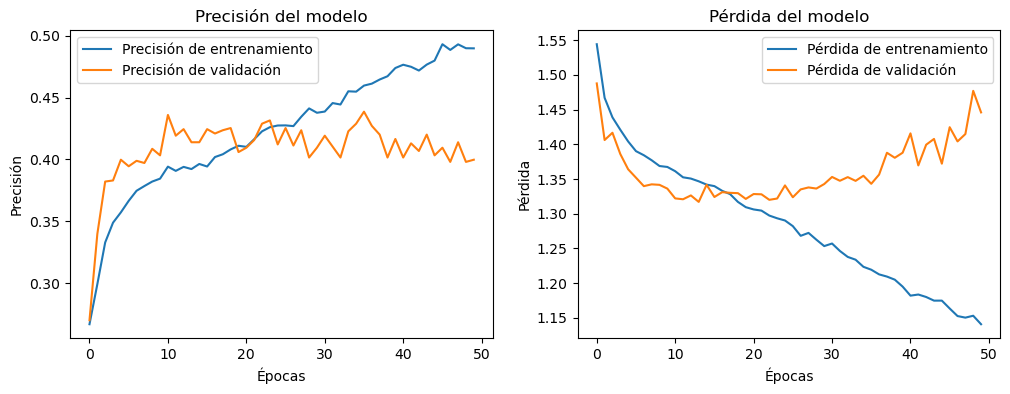

In [142]:
# Plotear la precisión del modelo
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Precisión de entrenamiento")
plt.plot(history.history["val_accuracy"], label="Precisión de validación")
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()

# Plotear la pérdida del modelo
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Pérdida de entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de validación")
plt.title("Pérdida del modelo")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()

plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step


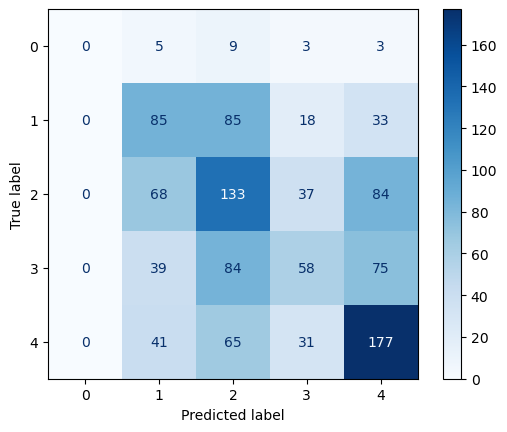

In [143]:
y_pred = model.predict(X_test_dict)
y_pred_classes = np.argmax(
    y_pred, axis=1
) 

# Calcular la matriz de confusión
cm = confusion_matrix(y_img_test, y_pred_classes)

# Plotear la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()